<a href="https://colab.research.google.com/github/Tasmia062/CSE-475-4--2021-2-60-062/blob/main/CSE475_lab4_yolov8_object_detection_xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Load Dataset**

In [1]:
!pip install roboflow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SzTQzA4EpeXuxZ4ByHpK")
project = rf.workspace("raiyan8018").project("ocean_waste-fdnf1")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ocean_waste-1 in yolov8:: 100%|██████████| 10284/10284 [00:01<00:00, 6011.56it/s]


In [4]:
# Print the dataset location
print(dataset.location)

# Inspect downloaded folder
!ls {dataset.location}

/content/ocean_waste-1
data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


##**Prepare Dataset**

In [5]:
# Paths to your dataset
train_images_path = os.path.join(dataset.location, "train", "images")
train_labels_path = os.path.join(dataset.location, "train", "labels")

val_images_path = os.path.join(dataset.location, "valid", "images")
val_labels_path = os.path.join(dataset.location, "valid", "labels")

test_images_path = os.path.join(dataset.location, "test", "images")
test_labels_path = os.path.join(dataset.location, "test", "labels")

In [6]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

##**EDA**

In [7]:
def inspect_folder(images_path, labels_path):
    num_images = len(os.listdir(images_path))
    num_labels = len(os.listdir(labels_path))
    print(f"Images: {num_images}, Labels: {num_labels}")

# Inspect each subset
print("Training Set:")
inspect_folder(train_images_path, train_labels_path)

print("\nValidation Set:")
inspect_folder(val_images_path, val_labels_path)

print("\nTesting Set:")
inspect_folder(test_images_path, test_labels_path)

Training Set:
Images: 3628, Labels: 3628

Validation Set:
Images: 1007, Labels: 1007

Testing Set:
Images: 501, Labels: 501


##**YOLOv8**

In [8]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=5 imgsz=224 plots=True

100% 21.5M/21.5M [00:00<00:00, 42.7MB/s]
Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/ocean_waste-1/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

In [10]:
import pandas as pd

# Path to results.csv
results_path = "/content/runs/detect/train/results.csv"

# Load results into a DataFrame
results = pd.read_csv(results_path)

# Display the metrics for the last epoch
print("Metrics from the final epoch:")
print(results.iloc[-1])  # Shows precision, recall, F1-score, mAP, etc.

Metrics from the final epoch:
epoch                     5.000000
time                    211.507000
train/box_loss            1.345760
train/cls_loss            1.247560
train/dfl_loss            1.234230
metrics/precision(B)      0.662670
metrics/recall(B)         0.418820
metrics/mAP50(B)          0.479870
metrics/mAP50-95(B)       0.318510
val/box_loss              1.267940
val/cls_loss              1.161790
val/dfl_loss              1.228730
lr/pg0                    0.000109
lr/pg1                    0.000109
lr/pg2                    0.000109
Name: 4, dtype: float64


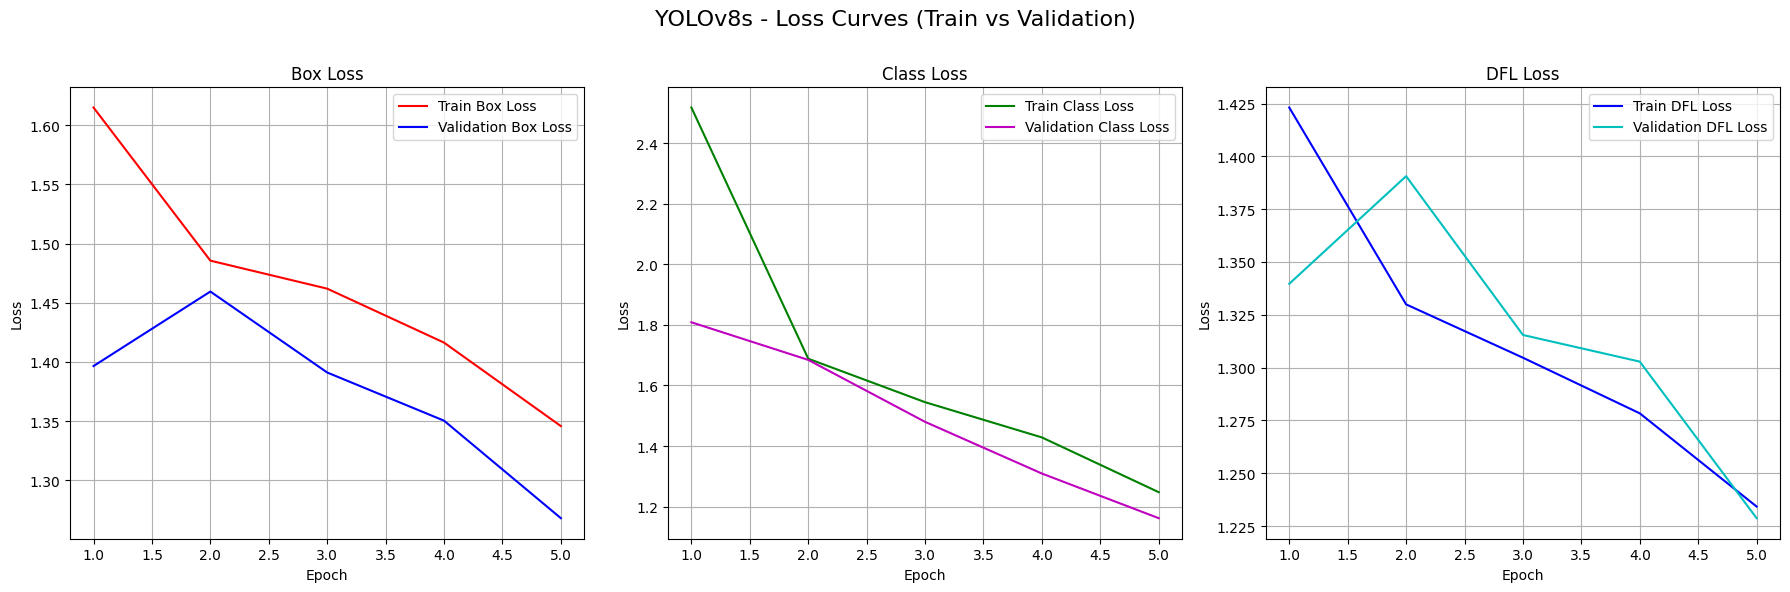

In [11]:
import matplotlib.pyplot as plt

# Assuming 'model_name' holds the name of your model
model_name = "YOLOv8s"

# Plot 1: Mixed Loss Curves (Training vs Validation)
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))
fig1.suptitle(f"{model_name} - Loss Curves (Train vs Validation)", fontsize=16)

# Mixed Box Loss (Train vs Validation)
axes1[0].plot(results['epoch'], results['train/box_loss'], label='Train Box Loss', color='r')
axes1[0].plot(results['epoch'], results['val/box_loss'], label='Validation Box Loss', color='b')
axes1[0].set_title("Box Loss")
axes1[0].set_xlabel("Epoch")
axes1[0].set_ylabel("Loss")
axes1[0].legend()
axes1[0].grid(True)

# Mixed Class Loss (Train vs Validation)
axes1[1].plot(results['epoch'], results['train/cls_loss'], label='Train Class Loss', color='g')
axes1[1].plot(results['epoch'], results['val/cls_loss'], label='Validation Class Loss', color='m')
axes1[1].set_title("Class Loss")
axes1[1].set_xlabel("Epoch")
axes1[1].set_ylabel("Loss")
axes1[1].legend()
axes1[1].grid(True)

# Mixed DFL Loss (Train vs Validation)
axes1[2].plot(results['epoch'], results['train/dfl_loss'], label='Train DFL Loss', color='b')
axes1[2].plot(results['epoch'], results['val/dfl_loss'], label='Validation DFL Loss', color='c')
axes1[2].set_title("DFL Loss")
axes1[2].set_xlabel("Epoch")
axes1[2].set_ylabel("Loss")
axes1[2].legend()
axes1[2].grid(True)

# Adjust layout for better spacing
fig1.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

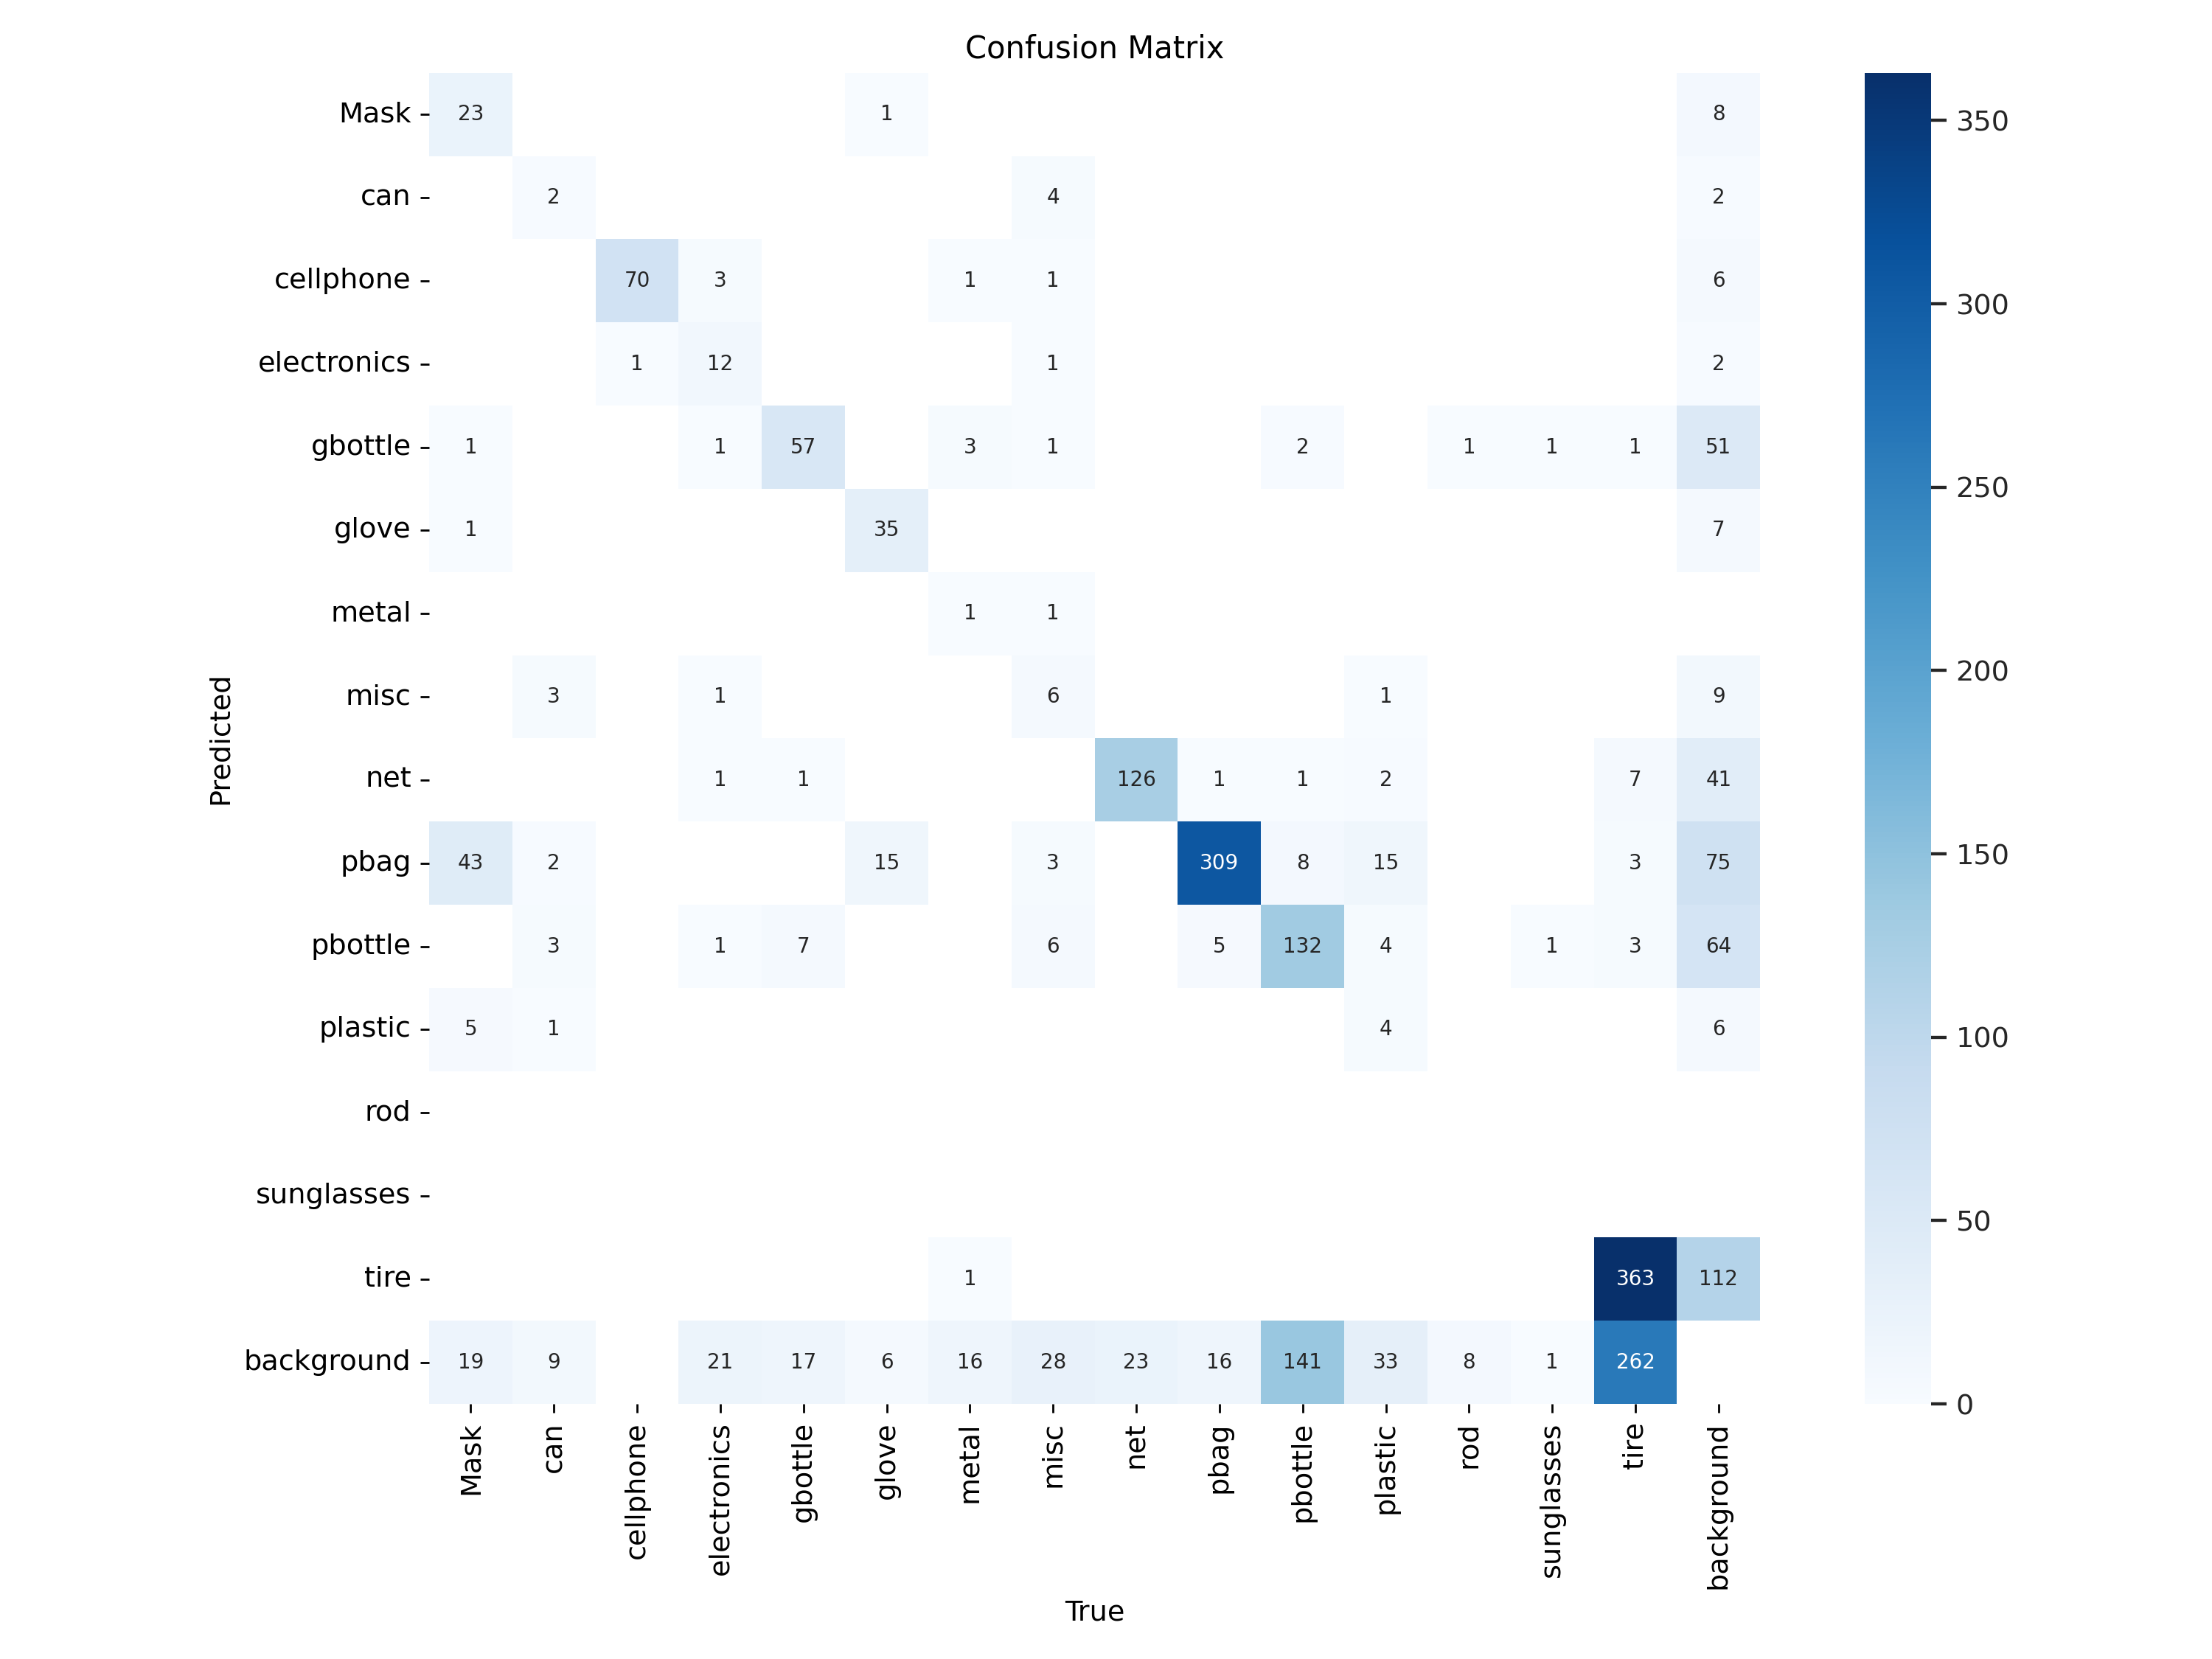

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train/confusion_matrix.png', width=600)

-------------------------------------------------------------------

In [14]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source=/content/ocean_waste-1/test/images save=True

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,131,389 parameters, 0 gradients, 28.5 GFLOPs

image 1/501 /content/ocean_waste-1/test/images/1bc7-iudfmpmn7245599_jpg.rf.806a02bbc3f08c3071599d083c4c8aa1.jpg: 224x224 1 glove, 19.3ms
image 2/501 /content/ocean_waste-1/test/images/200623160205-05-coronavirus-waste-pollution-super-169_jpg.rf.562f2af44ca9d9eaf0ca576de496b7ac.jpg: 128x224 1 pbag, 37.8ms
image 3/501 /content/ocean_waste-1/test/images/66b85ac2-5d1b-4783-b0fa-4f8adcda51a5_jpg.rf.846c9d5ff87c6ea5ee366b49f442d938.jpg: 160x224 2 pbags, 38.2ms
image 4/501 /content/ocean_waste-1/test/images/7_JPG_jpg.rf.ccb77282a0f5cbc35412a3171d86b48f.jpg: 224x128 1 Mask, 38.3ms
image 5/501 /content/ocean_waste-1/test/images/GettyImages-1227891345-1000x667_jpg.rf.1dffa4b987bd4b38a57278de03e0f424.jpg: 160x224 1 misc, 1 pbag, 7.7ms
image 6/501 /content/ocean_waste-1/test/images/GettyImageskl-1227891345-1000x667_jpg.rf.831a202ecda0

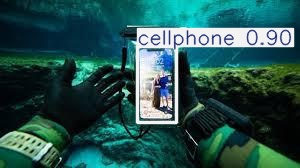

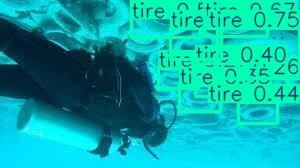

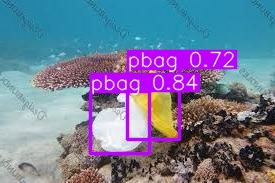

In [15]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
	display(IPyImage(filename=img, width=600))
	print("\n")

In [16]:
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 115 (delta 13), reused 8 (delta 8), pack-reused 94 (from 1)
Receiving objects: 100% (115/115), 41.00 MiB | 14.02 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [17]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io

In [18]:
!ls

ocean_waste-1  runs  yolo11n.pt  YOLO-V8-CAM  yolov8s.pt


In [19]:
%cd YOLO-V8-CAM

/content/YOLO-V8-CAM


In [20]:
!ls

images	LICENSE.txt  models  README.md	yolo_cam  YOLO_v11_EigenCAM.ipynb  YOLO_v8n_EigenCAM.ipynb


In [21]:
!pip install ttach

In [22]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [25]:
import cv2
import numpy as np

# Verify the image path first
image_path = '/content/ocean_waste-1/test/images/uwg_yt-84__fliph_jpg.rf.dbcd58bd17dd3d9c9c47c0215edce52c.jpg'
if not os.path.exists(image_path):
    print(f"Error: Image file not found at {image_path}")
else:
    img = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not load image from {image_path}")
    else:
        img = cv2.resize(img, (640, 640))
        rgb_img = img.copy()
        img = np.float32(img) / 255

In [26]:
import ultralytics
from ultralytics import YOLO
model = YOLO('/content/yolov8s.pt')
model.cpu()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [27]:
target_layers =[model.model.model[-2]]

In [28]:
cam = EigenCAM(model, target_layers,task='od')


0: 640x640 1 bird, 621.5ms
Speed: 6.2ms preprocess, 621.5ms inference, 19.1ms postprocess per image at shape (1, 3, 640, 640)


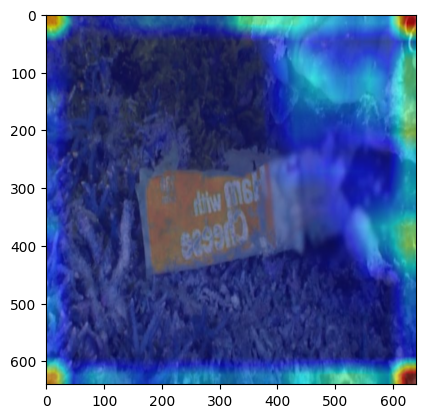

In [29]:
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()


0: 640x640 1 bird, 389.9ms
Speed: 3.9ms preprocess, 389.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


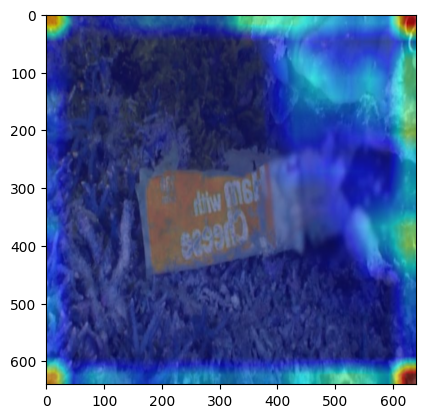

In [30]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [31]:
target_layers =[model.model.model[-2], model.model.model[-3], model.model.model[-4]]


0: 640x640 1 bird, 384.8ms
Speed: 3.9ms preprocess, 384.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


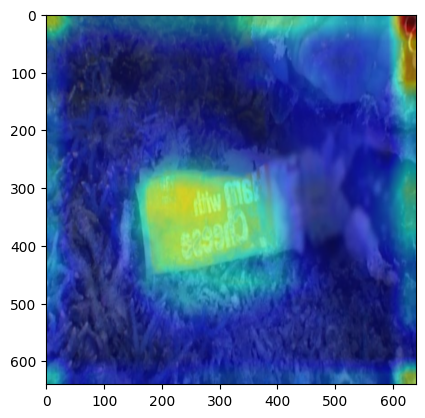

In [32]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

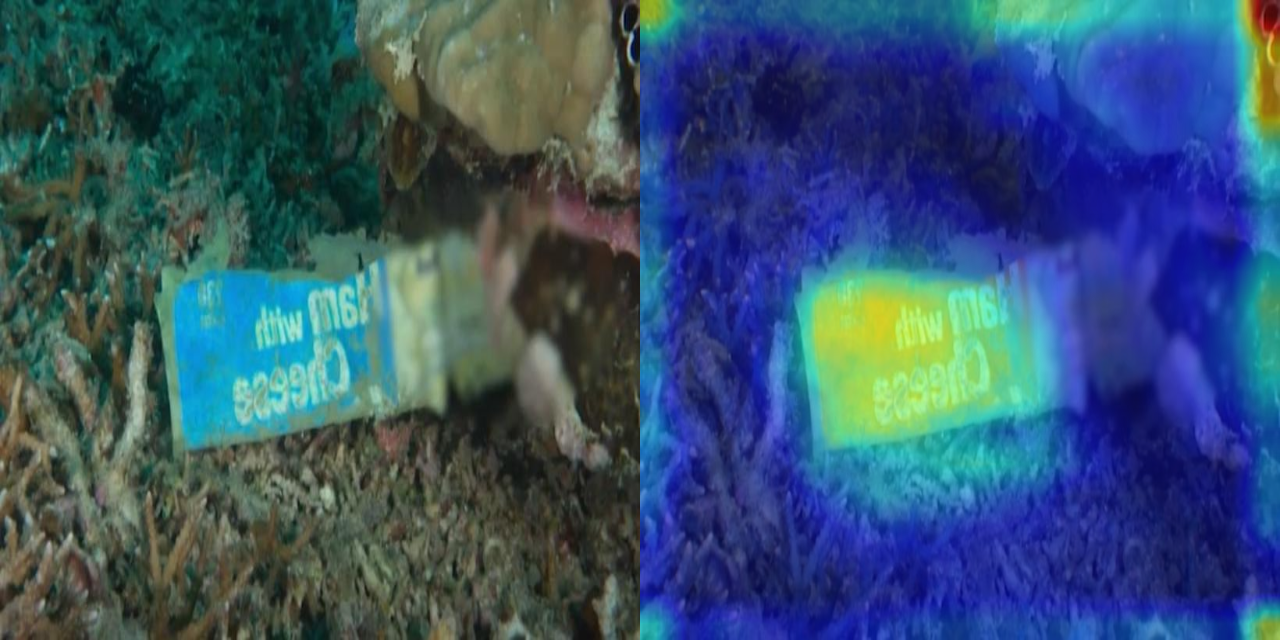

In [33]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))